# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

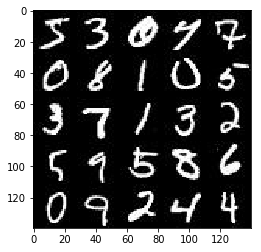

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

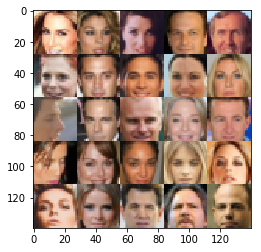

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import tensorflow as tf

# Rank means t
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Drop out rate
    drop_rate = 0.1
    # Alpha rate for leaky relu
    alpha = 0.2
    kernel_size = 3
    
    n_units = 128
    size_mult = 64
    x = images    
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.layers.conv2d(x, size_mult, kernel_size, strides=2, padding='same')
        dropout1 = tf.layers.dropout(x1, rate=drop_rate)
        relu1 = tf.maximum(alpha * dropout1, dropout1)
        
        x2 = tf.layers.conv2d(relu1, size_mult * 2, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(bn2, rate=drop_rate)
        relu2 = tf.maximum(alpha * dropout2, dropout2)
      
        x3 = tf.layers.conv2d(relu2, size_mult * 4, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flattening conv layer  
        features = tf.reshape(relu3, [-1, 4 * 4 * 256])
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, 1, activation=None)
        
        # Sigmoid and not softmax. Sigmoid because only 2 classes.
        out = tf.nn.sigmoid(class_logits)
        
    return out, class_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2
    n_units = 128
    kernel = 5
    stride = 2
    
    with tf.variable_scope("generator", reuse=reuse):
        
        # fully connected layer
        fc = tf.layers.dense(z, 2 * 2 * n_units * 4, activation=None)
        x1 = tf.reshape(fc, [-1, 2, 2, n_units * 4])   
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, n_units * 2, kernel, strides = stride, padding="valid")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, n_units, kernel, stride, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel, strides=stride, padding="same")
        
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # discriminator loss for the reals
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)
        )
    )
    
    # Discriminator loss for the fakes
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    # Summing the discriminator loss for reals and fake
    total_d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    return total_d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        
    # NN vars
    disc_vars = tf.trainable_variables("discriminator")
    gen_vars = tf.trainable_variables("generator")

    # Optimize 
    disc_trained = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = disc_vars)
        
    updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in updates if opt.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    d_train_opt = disc_trained
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    sample_z = np.random.normal(-0.8, 1, size=(batch_size, z_dim))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0    
    
    print_every = 10
    show_every = 40
    images_to_show = 25
    
    print(data_shape)
    width, height, channels = data_shape[1:]
    print("width: {}, height: {}, channels: {}".format(width, height, channels))
    print("Channel mode: {}".format(data_image_mode))
    
    
    # Getting the variables required for training 
    input_real, input_z, some_learning_rate = model_inputs(width, height, channels, z_dim)
    
    # Should use the channel mode to calculate the channels but using the number of channels works too
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                            
                batch_images *= 2.0
                    
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-0.8, 1, size=(batch_size, z_dim))
                
                # Run the optimizer for discriminator
                _ = sess.run(
                    d_train_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z,
                        some_learning_rate:learning_rate
                    }
                )
                
                # Run the optimizer for the generator
                _ = sess.run(
                    g_train_opt,
                    feed_dict={
                        input_z: batch_z, 
                        input_real: batch_images,
                        some_learning_rate:learning_rate
                    }
                )
                
                # Print out the losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({
                        input_real: batch_images,
                        input_z: batch_z
                    })
                    train_loss_g = g_loss.eval({
                        input_z: batch_z, 
                        input_real: batch_images
                    })
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show the generator output
                if steps % show_every == 0:
                    show_generator_output(
                        sess,
                        images_to_show,
                        input_z, 
                        channels,
                        data_image_mode
                    )
        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
width: 28, height: 28, channels: 1
Channel mode: L
Epoch 1/20... Discriminator Loss: 0.1491... Generator Loss: 6.0795
Epoch 1/20... Discriminator Loss: 1.4265... Generator Loss: 0.2914
Epoch 1/20... Discriminator Loss: 0.2476... Generator Loss: 8.5482
Epoch 1/20... Discriminator Loss: 0.2370... Generator Loss: 6.1758


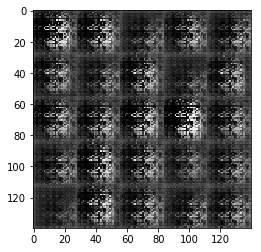

Epoch 1/20... Discriminator Loss: 0.6497... Generator Loss: 2.1973
Epoch 1/20... Discriminator Loss: 0.3429... Generator Loss: 1.8525
Epoch 1/20... Discriminator Loss: 0.6129... Generator Loss: 4.2195
Epoch 1/20... Discriminator Loss: 0.3770... Generator Loss: 2.6596


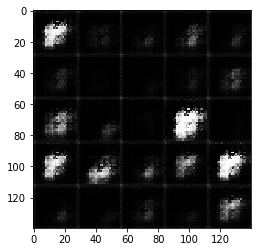

Epoch 1/20... Discriminator Loss: 0.4887... Generator Loss: 1.8171
Epoch 1/20... Discriminator Loss: 0.1583... Generator Loss: 2.6375
Epoch 1/20... Discriminator Loss: 0.7196... Generator Loss: 1.2489
Epoch 2/20... Discriminator Loss: 0.1127... Generator Loss: 3.4771


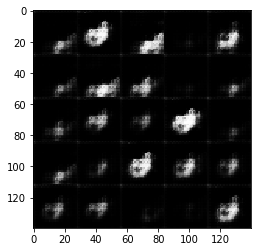

Epoch 2/20... Discriminator Loss: 0.1198... Generator Loss: 3.4499
Epoch 2/20... Discriminator Loss: 0.1089... Generator Loss: 4.4571
Epoch 2/20... Discriminator Loss: 0.1582... Generator Loss: 3.1257
Epoch 2/20... Discriminator Loss: 0.1353... Generator Loss: 5.5739


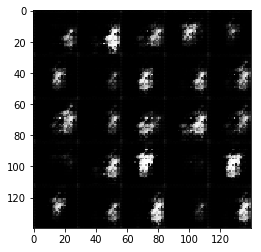

Epoch 2/20... Discriminator Loss: 0.2731... Generator Loss: 11.1879
Epoch 2/20... Discriminator Loss: 0.1008... Generator Loss: 3.7102
Epoch 2/20... Discriminator Loss: 0.3248... Generator Loss: 2.2112
Epoch 2/20... Discriminator Loss: 0.5996... Generator Loss: 6.8877


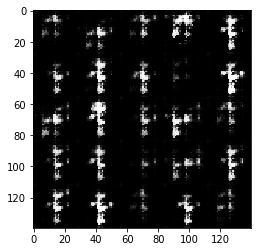

Epoch 2/20... Discriminator Loss: 0.4680... Generator Loss: 8.2305
Epoch 2/20... Discriminator Loss: 0.0988... Generator Loss: 3.9540
Epoch 2/20... Discriminator Loss: 0.1265... Generator Loss: 3.4269
Epoch 3/20... Discriminator Loss: 0.7484... Generator Loss: 6.9389


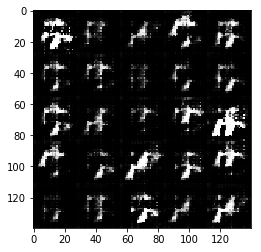

Epoch 3/20... Discriminator Loss: 0.3633... Generator Loss: 4.1272
Epoch 3/20... Discriminator Loss: 0.4191... Generator Loss: 3.6564
Epoch 3/20... Discriminator Loss: 0.2124... Generator Loss: 3.0466
Epoch 3/20... Discriminator Loss: 0.5290... Generator Loss: 2.8406


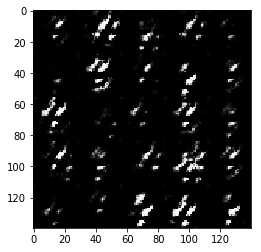

Epoch 3/20... Discriminator Loss: 0.1538... Generator Loss: 4.2019
Epoch 3/20... Discriminator Loss: 0.2344... Generator Loss: 2.9654
Epoch 3/20... Discriminator Loss: 0.5664... Generator Loss: 2.2377
Epoch 3/20... Discriminator Loss: 0.3361... Generator Loss: 2.4073


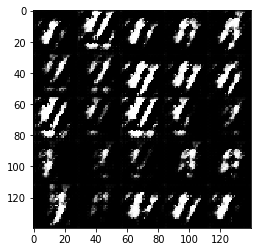

Epoch 3/20... Discriminator Loss: 0.4640... Generator Loss: 1.7790
Epoch 3/20... Discriminator Loss: 0.2573... Generator Loss: 3.2158
Epoch 3/20... Discriminator Loss: 0.3464... Generator Loss: 2.5671
Epoch 4/20... Discriminator Loss: 0.2671... Generator Loss: 3.7883


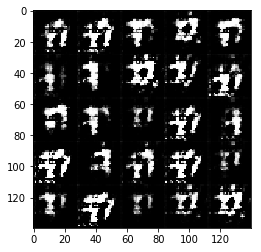

Epoch 4/20... Discriminator Loss: 0.6184... Generator Loss: 3.1311
Epoch 4/20... Discriminator Loss: 0.5058... Generator Loss: 3.3097
Epoch 4/20... Discriminator Loss: 0.1152... Generator Loss: 3.4737
Epoch 4/20... Discriminator Loss: 0.4028... Generator Loss: 1.7097


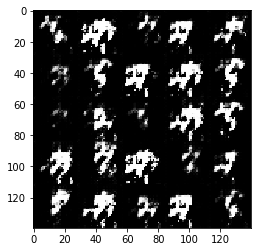

Epoch 4/20... Discriminator Loss: 0.2061... Generator Loss: 4.6060
Epoch 4/20... Discriminator Loss: 0.3427... Generator Loss: 2.3932
Epoch 4/20... Discriminator Loss: 0.3216... Generator Loss: 2.3807
Epoch 4/20... Discriminator Loss: 0.4674... Generator Loss: 2.2347


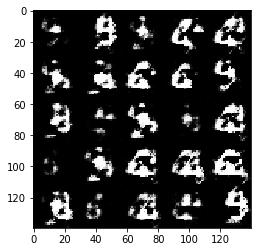

Epoch 4/20... Discriminator Loss: 0.3301... Generator Loss: 2.5086
Epoch 4/20... Discriminator Loss: 0.7281... Generator Loss: 3.6913
Epoch 5/20... Discriminator Loss: 0.6204... Generator Loss: 4.1051
Epoch 5/20... Discriminator Loss: 0.3532... Generator Loss: 2.4748


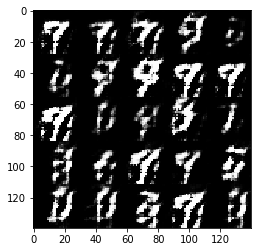

Epoch 5/20... Discriminator Loss: 0.3093... Generator Loss: 2.5553
Epoch 5/20... Discriminator Loss: 0.3155... Generator Loss: 2.8362
Epoch 5/20... Discriminator Loss: 0.3089... Generator Loss: 2.3784
Epoch 5/20... Discriminator Loss: 0.4414... Generator Loss: 3.4932


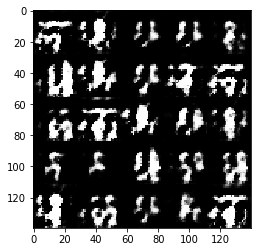

Epoch 5/20... Discriminator Loss: 0.2740... Generator Loss: 2.5687
Epoch 5/20... Discriminator Loss: 0.2814... Generator Loss: 2.7602
Epoch 5/20... Discriminator Loss: 0.3082... Generator Loss: 2.7247
Epoch 5/20... Discriminator Loss: 0.4861... Generator Loss: 2.5455


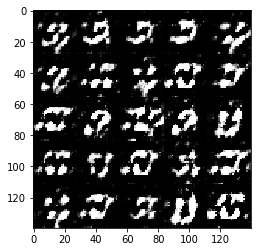

Epoch 5/20... Discriminator Loss: 0.5730... Generator Loss: 2.3838
Epoch 5/20... Discriminator Loss: 0.4302... Generator Loss: 3.7109
Epoch 6/20... Discriminator Loss: 0.5458... Generator Loss: 1.5095
Epoch 6/20... Discriminator Loss: 0.3118... Generator Loss: 3.1480


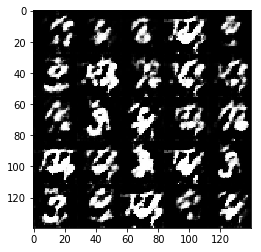

Epoch 6/20... Discriminator Loss: 0.2024... Generator Loss: 2.7865
Epoch 6/20... Discriminator Loss: 0.3808... Generator Loss: 1.7145
Epoch 6/20... Discriminator Loss: 0.3322... Generator Loss: 2.0777
Epoch 6/20... Discriminator Loss: 0.2189... Generator Loss: 2.7055


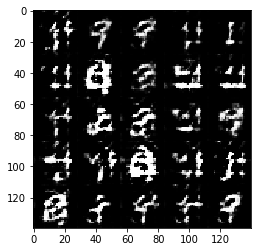

Epoch 6/20... Discriminator Loss: 0.5402... Generator Loss: 1.4553
Epoch 6/20... Discriminator Loss: 0.2923... Generator Loss: 2.7950
Epoch 6/20... Discriminator Loss: 0.7018... Generator Loss: 1.0120
Epoch 6/20... Discriminator Loss: 0.6505... Generator Loss: 4.4567


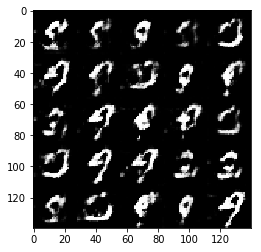

Epoch 6/20... Discriminator Loss: 0.2725... Generator Loss: 2.2885
Epoch 6/20... Discriminator Loss: 0.3306... Generator Loss: 2.5369
Epoch 7/20... Discriminator Loss: 0.2260... Generator Loss: 3.1994
Epoch 7/20... Discriminator Loss: 0.1961... Generator Loss: 3.2252


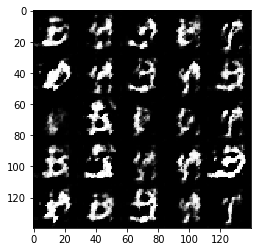

Epoch 7/20... Discriminator Loss: 0.4753... Generator Loss: 1.5908
Epoch 7/20... Discriminator Loss: 0.2551... Generator Loss: 2.8757
Epoch 7/20... Discriminator Loss: 0.2900... Generator Loss: 2.9147
Epoch 7/20... Discriminator Loss: 0.7461... Generator Loss: 6.2637


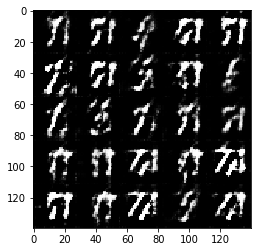

Epoch 7/20... Discriminator Loss: 0.9219... Generator Loss: 5.9061
Epoch 7/20... Discriminator Loss: 0.3463... Generator Loss: 2.3331
Epoch 7/20... Discriminator Loss: 0.3606... Generator Loss: 2.2279
Epoch 7/20... Discriminator Loss: 0.6477... Generator Loss: 1.4004


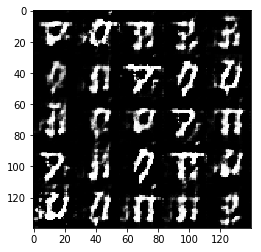

Epoch 7/20... Discriminator Loss: 0.8007... Generator Loss: 0.9423
Epoch 8/20... Discriminator Loss: 0.4444... Generator Loss: 2.0184
Epoch 8/20... Discriminator Loss: 0.6824... Generator Loss: 3.2508
Epoch 8/20... Discriminator Loss: 0.3798... Generator Loss: 2.1275


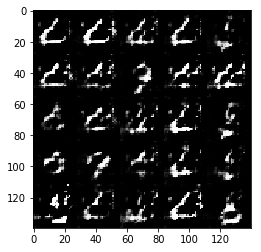

Epoch 8/20... Discriminator Loss: 0.4104... Generator Loss: 2.3411
Epoch 8/20... Discriminator Loss: 0.3648... Generator Loss: 3.6781
Epoch 8/20... Discriminator Loss: 0.3643... Generator Loss: 4.8755
Epoch 8/20... Discriminator Loss: 0.2956... Generator Loss: 2.2599


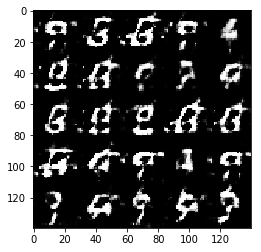

Epoch 8/20... Discriminator Loss: 0.4195... Generator Loss: 1.6637
Epoch 8/20... Discriminator Loss: 0.2866... Generator Loss: 2.1583
Epoch 8/20... Discriminator Loss: 1.7945... Generator Loss: 8.1142
Epoch 8/20... Discriminator Loss: 0.3042... Generator Loss: 2.3456


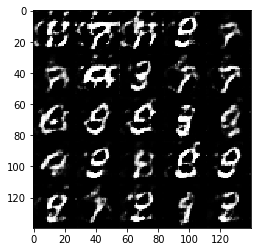

Epoch 8/20... Discriminator Loss: 0.4245... Generator Loss: 1.4922
Epoch 9/20... Discriminator Loss: 0.5402... Generator Loss: 1.9405
Epoch 9/20... Discriminator Loss: 0.4081... Generator Loss: 2.3807
Epoch 9/20... Discriminator Loss: 0.2364... Generator Loss: 2.6386


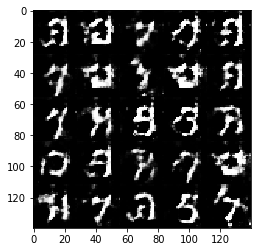

Epoch 9/20... Discriminator Loss: 0.5470... Generator Loss: 3.8327
Epoch 9/20... Discriminator Loss: 0.4820... Generator Loss: 1.8639
Epoch 9/20... Discriminator Loss: 0.5253... Generator Loss: 1.7145
Epoch 9/20... Discriminator Loss: 0.5917... Generator Loss: 1.3708


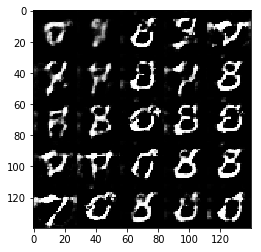

Epoch 9/20... Discriminator Loss: 0.7615... Generator Loss: 3.1116
Epoch 9/20... Discriminator Loss: 0.4081... Generator Loss: 1.8571
Epoch 9/20... Discriminator Loss: 0.4214... Generator Loss: 2.1898
Epoch 9/20... Discriminator Loss: 0.5006... Generator Loss: 2.7553


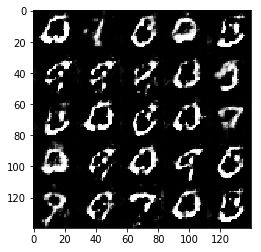

Epoch 9/20... Discriminator Loss: 2.0525... Generator Loss: 7.2338
Epoch 10/20... Discriminator Loss: 0.6399... Generator Loss: 1.6049
Epoch 10/20... Discriminator Loss: 0.4383... Generator Loss: 2.7124
Epoch 10/20... Discriminator Loss: 0.7430... Generator Loss: 3.8890


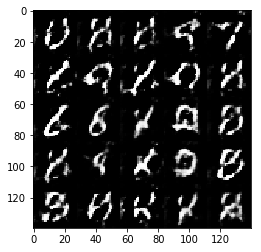

Epoch 10/20... Discriminator Loss: 0.7262... Generator Loss: 1.9928
Epoch 10/20... Discriminator Loss: 0.3899... Generator Loss: 2.2566
Epoch 10/20... Discriminator Loss: 0.6368... Generator Loss: 1.1258
Epoch 10/20... Discriminator Loss: 0.4460... Generator Loss: 1.6005


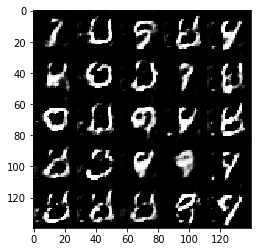

Epoch 10/20... Discriminator Loss: 0.5402... Generator Loss: 1.3774
Epoch 10/20... Discriminator Loss: 0.4339... Generator Loss: 1.9065
Epoch 10/20... Discriminator Loss: 0.4238... Generator Loss: 1.8380
Epoch 10/20... Discriminator Loss: 0.5328... Generator Loss: 3.5720


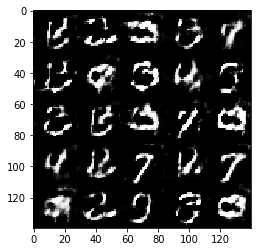

Epoch 10/20... Discriminator Loss: 0.6370... Generator Loss: 1.2624
Epoch 11/20... Discriminator Loss: 0.9215... Generator Loss: 3.1627
Epoch 11/20... Discriminator Loss: 0.3779... Generator Loss: 2.1986
Epoch 11/20... Discriminator Loss: 0.5182... Generator Loss: 1.3411


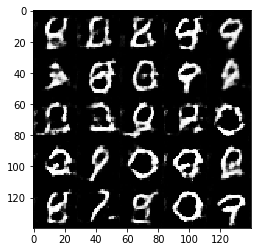

Epoch 11/20... Discriminator Loss: 0.5451... Generator Loss: 1.7975
Epoch 11/20... Discriminator Loss: 0.4561... Generator Loss: 1.4653
Epoch 11/20... Discriminator Loss: 0.8371... Generator Loss: 0.8071
Epoch 11/20... Discriminator Loss: 0.7729... Generator Loss: 2.2923


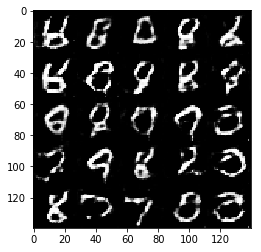

Epoch 11/20... Discriminator Loss: 0.4736... Generator Loss: 1.8178
Epoch 11/20... Discriminator Loss: 0.5952... Generator Loss: 1.2343
Epoch 11/20... Discriminator Loss: 0.7869... Generator Loss: 2.9711
Epoch 11/20... Discriminator Loss: 1.4832... Generator Loss: 0.4867


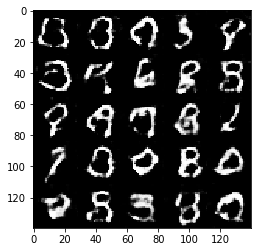

Epoch 12/20... Discriminator Loss: 0.9343... Generator Loss: 0.7582
Epoch 12/20... Discriminator Loss: 0.5842... Generator Loss: 1.5233
Epoch 12/20... Discriminator Loss: 0.9101... Generator Loss: 0.6844
Epoch 12/20... Discriminator Loss: 0.5118... Generator Loss: 1.5321


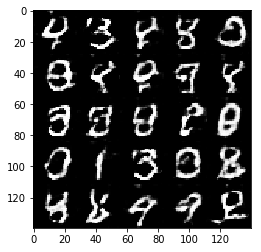

Epoch 12/20... Discriminator Loss: 0.5419... Generator Loss: 2.2037
Epoch 12/20... Discriminator Loss: 0.4489... Generator Loss: 1.7505
Epoch 12/20... Discriminator Loss: 0.6805... Generator Loss: 0.9670
Epoch 12/20... Discriminator Loss: 0.5022... Generator Loss: 2.4018


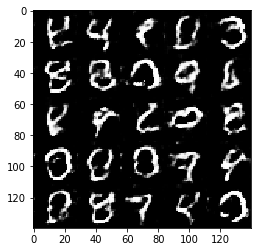

Epoch 12/20... Discriminator Loss: 0.8236... Generator Loss: 0.8967
Epoch 12/20... Discriminator Loss: 0.5430... Generator Loss: 2.3030
Epoch 12/20... Discriminator Loss: 0.4638... Generator Loss: 1.5939
Epoch 12/20... Discriminator Loss: 2.1295... Generator Loss: 3.8153


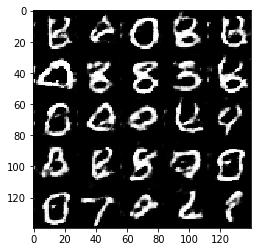

Epoch 13/20... Discriminator Loss: 1.1181... Generator Loss: 1.8528
Epoch 13/20... Discriminator Loss: 1.3908... Generator Loss: 0.4323
Epoch 13/20... Discriminator Loss: 0.7974... Generator Loss: 1.1649
Epoch 13/20... Discriminator Loss: 0.7452... Generator Loss: 1.1154


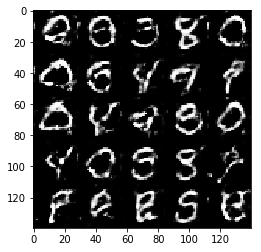

Epoch 13/20... Discriminator Loss: 0.6680... Generator Loss: 1.7905
Epoch 13/20... Discriminator Loss: 0.6079... Generator Loss: 1.0943
Epoch 13/20... Discriminator Loss: 0.5904... Generator Loss: 1.3993
Epoch 13/20... Discriminator Loss: 0.8693... Generator Loss: 0.9185


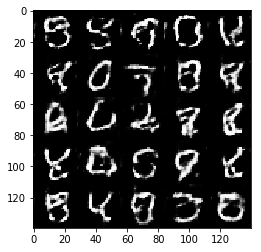

Epoch 13/20... Discriminator Loss: 0.6634... Generator Loss: 2.8706
Epoch 13/20... Discriminator Loss: 0.7654... Generator Loss: 0.8631
Epoch 13/20... Discriminator Loss: 0.4959... Generator Loss: 1.7894
Epoch 13/20... Discriminator Loss: 0.7802... Generator Loss: 1.0221


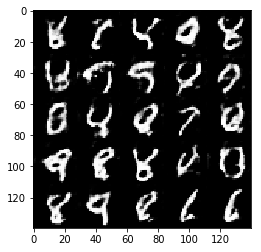

Epoch 14/20... Discriminator Loss: 0.9415... Generator Loss: 0.6704
Epoch 14/20... Discriminator Loss: 0.7128... Generator Loss: 2.0900
Epoch 14/20... Discriminator Loss: 2.2479... Generator Loss: 4.4077
Epoch 14/20... Discriminator Loss: 0.7213... Generator Loss: 2.4904


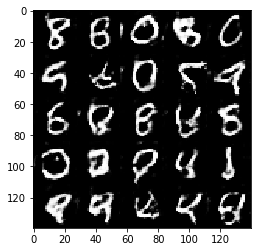

Epoch 14/20... Discriminator Loss: 1.2132... Generator Loss: 2.7640
Epoch 14/20... Discriminator Loss: 1.1049... Generator Loss: 1.9131
Epoch 14/20... Discriminator Loss: 0.6925... Generator Loss: 1.1837
Epoch 14/20... Discriminator Loss: 0.5776... Generator Loss: 1.5377


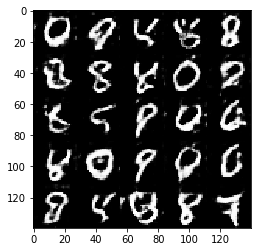

Epoch 14/20... Discriminator Loss: 0.8166... Generator Loss: 2.2769
Epoch 14/20... Discriminator Loss: 0.6602... Generator Loss: 1.6113
Epoch 14/20... Discriminator Loss: 1.4325... Generator Loss: 3.3087
Epoch 15/20... Discriminator Loss: 0.5579... Generator Loss: 1.6612


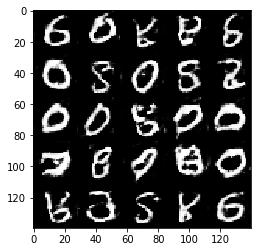

Epoch 15/20... Discriminator Loss: 0.9082... Generator Loss: 2.0022
Epoch 15/20... Discriminator Loss: 0.6877... Generator Loss: 1.0142
Epoch 15/20... Discriminator Loss: 0.6750... Generator Loss: 1.1147
Epoch 15/20... Discriminator Loss: 1.2941... Generator Loss: 0.4219


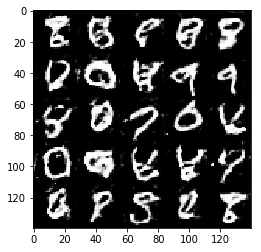

Epoch 15/20... Discriminator Loss: 0.9002... Generator Loss: 0.7432
Epoch 15/20... Discriminator Loss: 1.8565... Generator Loss: 3.6279
Epoch 15/20... Discriminator Loss: 0.6963... Generator Loss: 1.4699
Epoch 15/20... Discriminator Loss: 0.7768... Generator Loss: 1.9078


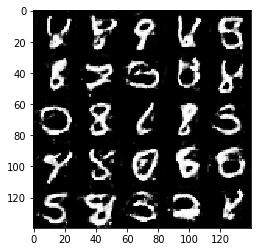

Epoch 15/20... Discriminator Loss: 0.5994... Generator Loss: 1.2809
Epoch 15/20... Discriminator Loss: 1.2808... Generator Loss: 0.4411
Epoch 15/20... Discriminator Loss: 1.0608... Generator Loss: 0.6629
Epoch 16/20... Discriminator Loss: 1.4714... Generator Loss: 0.3325


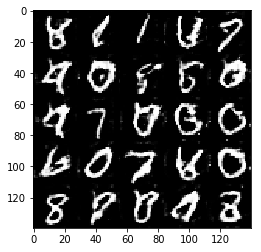

Epoch 16/20... Discriminator Loss: 1.0668... Generator Loss: 2.4682
Epoch 16/20... Discriminator Loss: 0.6741... Generator Loss: 1.1275
Epoch 16/20... Discriminator Loss: 0.6520... Generator Loss: 1.5666
Epoch 16/20... Discriminator Loss: 2.3648... Generator Loss: 3.3875


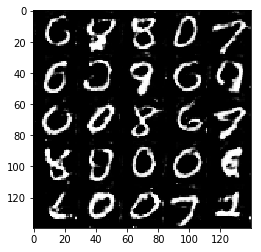

Epoch 16/20... Discriminator Loss: 0.8936... Generator Loss: 1.6227
Epoch 16/20... Discriminator Loss: 0.8681... Generator Loss: 1.8360
Epoch 16/20... Discriminator Loss: 0.5903... Generator Loss: 1.4260
Epoch 16/20... Discriminator Loss: 0.9477... Generator Loss: 2.1383


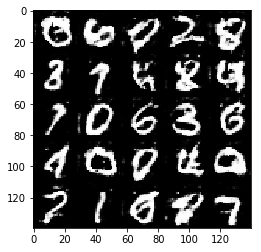

Epoch 16/20... Discriminator Loss: 0.7573... Generator Loss: 2.2655
Epoch 16/20... Discriminator Loss: 0.5618... Generator Loss: 2.0830
Epoch 16/20... Discriminator Loss: 0.9093... Generator Loss: 0.9826
Epoch 17/20... Discriminator Loss: 1.2554... Generator Loss: 2.8883


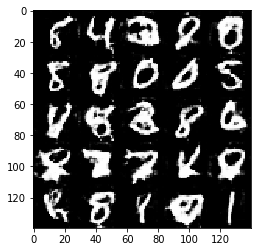

Epoch 17/20... Discriminator Loss: 0.6172... Generator Loss: 1.1615
Epoch 17/20... Discriminator Loss: 1.3127... Generator Loss: 0.4274
Epoch 17/20... Discriminator Loss: 0.8798... Generator Loss: 0.7805
Epoch 17/20... Discriminator Loss: 0.8629... Generator Loss: 0.7457


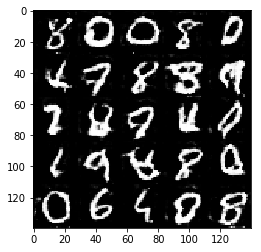

Epoch 17/20... Discriminator Loss: 0.4963... Generator Loss: 1.4983
Epoch 17/20... Discriminator Loss: 1.6302... Generator Loss: 0.3073
Epoch 17/20... Discriminator Loss: 1.1183... Generator Loss: 1.1880
Epoch 17/20... Discriminator Loss: 0.9466... Generator Loss: 1.3242


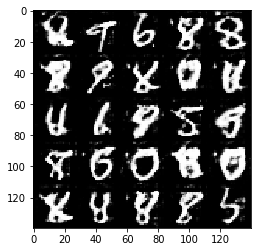

Epoch 17/20... Discriminator Loss: 0.9300... Generator Loss: 0.8940
Epoch 17/20... Discriminator Loss: 1.4522... Generator Loss: 0.3752
Epoch 18/20... Discriminator Loss: 0.8541... Generator Loss: 0.9245
Epoch 18/20... Discriminator Loss: 0.6256... Generator Loss: 1.4069


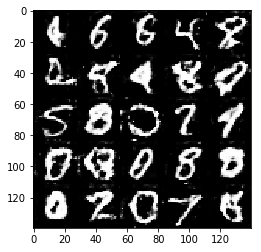

Epoch 18/20... Discriminator Loss: 0.7133... Generator Loss: 1.1236
Epoch 18/20... Discriminator Loss: 0.8598... Generator Loss: 0.7565
Epoch 18/20... Discriminator Loss: 1.1962... Generator Loss: 2.9296
Epoch 18/20... Discriminator Loss: 0.5505... Generator Loss: 1.7663


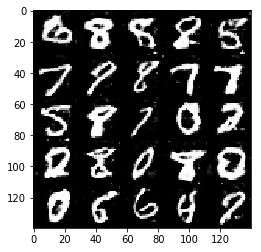

Epoch 18/20... Discriminator Loss: 1.7729... Generator Loss: 4.2052
Epoch 18/20... Discriminator Loss: 1.1289... Generator Loss: 2.2652
Epoch 18/20... Discriminator Loss: 0.6200... Generator Loss: 1.2923
Epoch 18/20... Discriminator Loss: 0.4824... Generator Loss: 2.0001


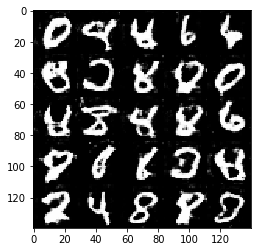

Epoch 18/20... Discriminator Loss: 0.6319... Generator Loss: 2.3448
Epoch 18/20... Discriminator Loss: 0.8333... Generator Loss: 3.5548
Epoch 19/20... Discriminator Loss: 0.9743... Generator Loss: 2.8993
Epoch 19/20... Discriminator Loss: 0.6430... Generator Loss: 1.5233


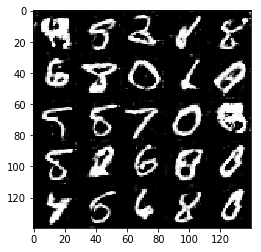

Epoch 19/20... Discriminator Loss: 5.6279... Generator Loss: 6.8066
Epoch 19/20... Discriminator Loss: 1.3166... Generator Loss: 0.5149
Epoch 19/20... Discriminator Loss: 0.7334... Generator Loss: 1.6557
Epoch 19/20... Discriminator Loss: 0.7472... Generator Loss: 1.2743


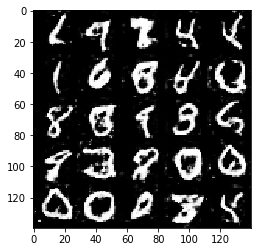

Epoch 19/20... Discriminator Loss: 0.7605... Generator Loss: 0.9926
Epoch 19/20... Discriminator Loss: 0.6170... Generator Loss: 1.0665
Epoch 19/20... Discriminator Loss: 0.7421... Generator Loss: 0.9681
Epoch 19/20... Discriminator Loss: 0.6515... Generator Loss: 0.9761


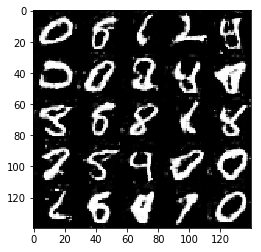

Epoch 19/20... Discriminator Loss: 0.4255... Generator Loss: 1.7425
Epoch 19/20... Discriminator Loss: 0.6939... Generator Loss: 1.5228
Epoch 20/20... Discriminator Loss: 1.1501... Generator Loss: 0.5108
Epoch 20/20... Discriminator Loss: 0.5328... Generator Loss: 1.4535


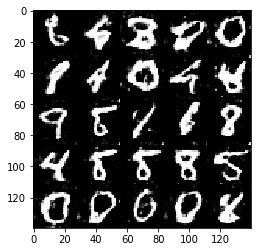

Epoch 20/20... Discriminator Loss: 0.7155... Generator Loss: 1.0537
Epoch 20/20... Discriminator Loss: 0.5154... Generator Loss: 1.8091
Epoch 20/20... Discriminator Loss: 0.4416... Generator Loss: 1.8358
Epoch 20/20... Discriminator Loss: 0.5387... Generator Loss: 1.3477


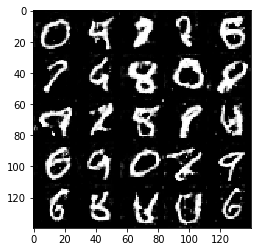

Epoch 20/20... Discriminator Loss: 1.0887... Generator Loss: 3.3274
Epoch 20/20... Discriminator Loss: 0.7622... Generator Loss: 0.9245
Epoch 20/20... Discriminator Loss: 0.5403... Generator Loss: 1.3633
Epoch 20/20... Discriminator Loss: 0.4866... Generator Loss: 1.7188


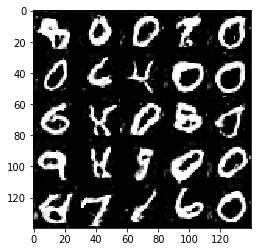

Epoch 20/20... Discriminator Loss: 0.2823... Generator Loss: 1.9648
Epoch 20/20... Discriminator Loss: 1.3321... Generator Loss: 4.0926


In [12]:
batch_size = 512
z_dim = 110
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
width: 28, height: 28, channels: 3
Channel mode: RGB
Epoch 1/6... Discriminator Loss: 1.6374... Generator Loss: 0.3146
Epoch 1/6... Discriminator Loss: 0.3586... Generator Loss: 7.5088
Epoch 1/6... Discriminator Loss: 2.6547... Generator Loss: 0.0958
Epoch 1/6... Discriminator Loss: 1.5169... Generator Loss: 7.9081


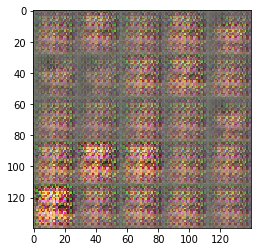

Epoch 1/6... Discriminator Loss: 0.3634... Generator Loss: 5.4523
Epoch 1/6... Discriminator Loss: 0.6981... Generator Loss: 1.2266
Epoch 1/6... Discriminator Loss: 0.6492... Generator Loss: 1.2811
Epoch 1/6... Discriminator Loss: 0.6998... Generator Loss: 1.2286


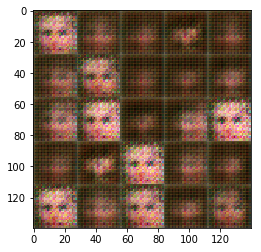

Epoch 1/6... Discriminator Loss: 1.4276... Generator Loss: 4.7287
Epoch 1/6... Discriminator Loss: 0.9460... Generator Loss: 0.8356
Epoch 1/6... Discriminator Loss: 1.2167... Generator Loss: 0.5244
Epoch 1/6... Discriminator Loss: 0.9320... Generator Loss: 4.8716


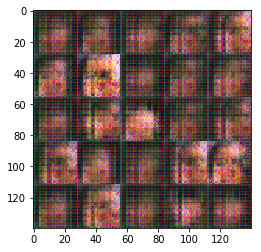

Epoch 1/6... Discriminator Loss: 1.1095... Generator Loss: 0.6310
Epoch 1/6... Discriminator Loss: 1.4586... Generator Loss: 0.4184
Epoch 1/6... Discriminator Loss: 1.4156... Generator Loss: 1.6552
Epoch 1/6... Discriminator Loss: 1.1354... Generator Loss: 0.8923


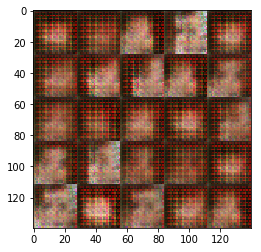

Epoch 1/6... Discriminator Loss: 1.2547... Generator Loss: 1.2793
Epoch 1/6... Discriminator Loss: 1.2574... Generator Loss: 0.7089
Epoch 1/6... Discriminator Loss: 1.3231... Generator Loss: 1.4641
Epoch 1/6... Discriminator Loss: 1.2457... Generator Loss: 1.4705


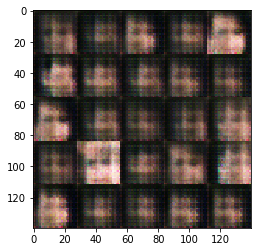

Epoch 1/6... Discriminator Loss: 1.5705... Generator Loss: 1.1165
Epoch 1/6... Discriminator Loss: 1.0528... Generator Loss: 1.0722
Epoch 1/6... Discriminator Loss: 1.6877... Generator Loss: 1.4645
Epoch 1/6... Discriminator Loss: 1.4828... Generator Loss: 0.8611


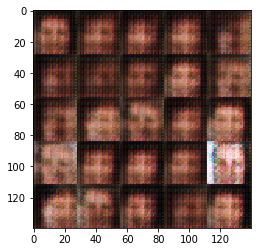

Epoch 1/6... Discriminator Loss: 0.7905... Generator Loss: 1.1908
Epoch 1/6... Discriminator Loss: 1.0371... Generator Loss: 1.2682
Epoch 1/6... Discriminator Loss: 0.8021... Generator Loss: 1.5384
Epoch 1/6... Discriminator Loss: 1.0946... Generator Loss: 1.0865


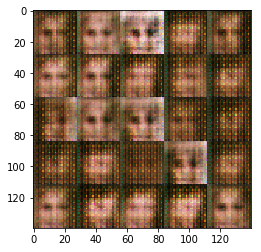

Epoch 1/6... Discriminator Loss: 0.9519... Generator Loss: 0.9576
Epoch 1/6... Discriminator Loss: 1.4082... Generator Loss: 0.6489
Epoch 1/6... Discriminator Loss: 1.3670... Generator Loss: 2.6626
Epoch 1/6... Discriminator Loss: 0.9985... Generator Loss: 0.8162


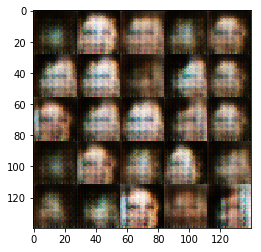

Epoch 1/6... Discriminator Loss: 1.1566... Generator Loss: 2.0300
Epoch 1/6... Discriminator Loss: 3.0125... Generator Loss: 5.0785
Epoch 1/6... Discriminator Loss: 1.3319... Generator Loss: 0.9161
Epoch 1/6... Discriminator Loss: 1.0845... Generator Loss: 1.0712


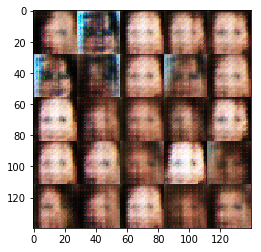

Epoch 1/6... Discriminator Loss: 1.0278... Generator Loss: 1.1475
Epoch 1/6... Discriminator Loss: 1.4431... Generator Loss: 0.9889
Epoch 1/6... Discriminator Loss: 1.3412... Generator Loss: 1.2954
Epoch 2/6... Discriminator Loss: 1.5982... Generator Loss: 0.9019


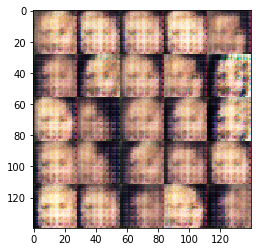

Epoch 2/6... Discriminator Loss: 1.7592... Generator Loss: 0.5186
Epoch 2/6... Discriminator Loss: 1.2095... Generator Loss: 0.7732
Epoch 2/6... Discriminator Loss: 1.2482... Generator Loss: 2.5927
Epoch 2/6... Discriminator Loss: 0.8062... Generator Loss: 1.2563


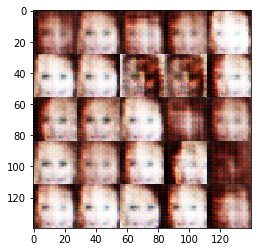

Epoch 2/6... Discriminator Loss: 0.9619... Generator Loss: 1.4948
Epoch 2/6... Discriminator Loss: 0.9379... Generator Loss: 0.9298
Epoch 2/6... Discriminator Loss: 0.8790... Generator Loss: 1.5649
Epoch 2/6... Discriminator Loss: 1.2244... Generator Loss: 0.6817


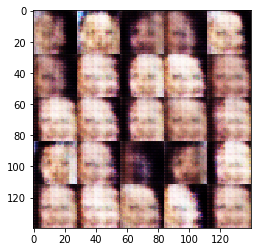

Epoch 2/6... Discriminator Loss: 1.0443... Generator Loss: 2.1696
Epoch 2/6... Discriminator Loss: 0.9282... Generator Loss: 1.1422
Epoch 2/6... Discriminator Loss: 0.9605... Generator Loss: 1.2793
Epoch 2/6... Discriminator Loss: 0.7867... Generator Loss: 1.1020


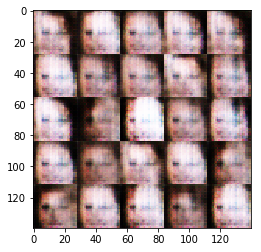

Epoch 2/6... Discriminator Loss: 0.8074... Generator Loss: 1.2437
Epoch 2/6... Discriminator Loss: 0.8006... Generator Loss: 1.2691
Epoch 2/6... Discriminator Loss: 0.9966... Generator Loss: 1.1320
Epoch 2/6... Discriminator Loss: 1.2180... Generator Loss: 1.1248


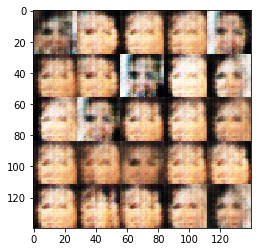

Epoch 2/6... Discriminator Loss: 0.9906... Generator Loss: 1.1713
Epoch 2/6... Discriminator Loss: 1.1494... Generator Loss: 0.6116
Epoch 2/6... Discriminator Loss: 0.9051... Generator Loss: 1.0765
Epoch 2/6... Discriminator Loss: 0.8729... Generator Loss: 0.9093


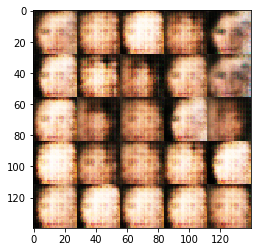

Epoch 2/6... Discriminator Loss: 0.9586... Generator Loss: 0.8608
Epoch 2/6... Discriminator Loss: 0.9338... Generator Loss: 2.1712
Epoch 2/6... Discriminator Loss: 0.8630... Generator Loss: 1.8922
Epoch 2/6... Discriminator Loss: 1.0574... Generator Loss: 1.1404


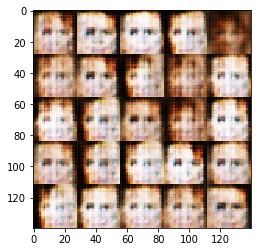

Epoch 2/6... Discriminator Loss: 0.8967... Generator Loss: 2.3576
Epoch 2/6... Discriminator Loss: 0.7793... Generator Loss: 1.3686
Epoch 2/6... Discriminator Loss: 1.1318... Generator Loss: 2.5217
Epoch 2/6... Discriminator Loss: 0.9534... Generator Loss: 1.1420


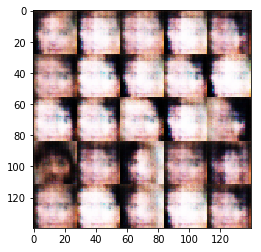

Epoch 2/6... Discriminator Loss: 0.7072... Generator Loss: 2.1296
Epoch 2/6... Discriminator Loss: 0.9292... Generator Loss: 0.9843
Epoch 2/6... Discriminator Loss: 1.3849... Generator Loss: 4.7654
Epoch 2/6... Discriminator Loss: 1.5762... Generator Loss: 3.3815


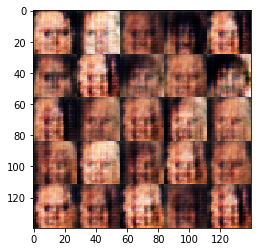

Epoch 2/6... Discriminator Loss: 0.9172... Generator Loss: 1.3838
Epoch 2/6... Discriminator Loss: 0.8372... Generator Loss: 1.2994
Epoch 2/6... Discriminator Loss: 0.8802... Generator Loss: 1.2745
Epoch 2/6... Discriminator Loss: 1.1405... Generator Loss: 0.7076


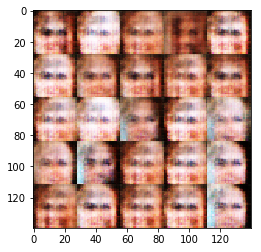

Epoch 2/6... Discriminator Loss: 0.6838... Generator Loss: 1.3145
Epoch 2/6... Discriminator Loss: 1.8897... Generator Loss: 4.8835
Epoch 2/6... Discriminator Loss: 0.8379... Generator Loss: 1.0399
Epoch 3/6... Discriminator Loss: 0.8075... Generator Loss: 1.4206


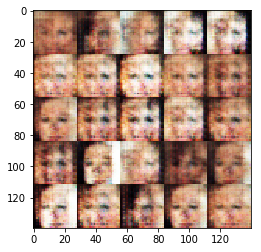

Epoch 3/6... Discriminator Loss: 1.0332... Generator Loss: 2.5841
Epoch 3/6... Discriminator Loss: 1.3075... Generator Loss: 0.5576
Epoch 3/6... Discriminator Loss: 0.8597... Generator Loss: 1.3967
Epoch 3/6... Discriminator Loss: 0.8418... Generator Loss: 1.0640


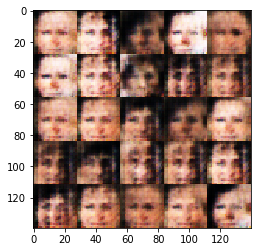

Epoch 3/6... Discriminator Loss: 0.5581... Generator Loss: 1.7804
Epoch 3/6... Discriminator Loss: 0.9878... Generator Loss: 2.9666
Epoch 3/6... Discriminator Loss: 0.7604... Generator Loss: 1.7079
Epoch 3/6... Discriminator Loss: 0.8447... Generator Loss: 1.0619


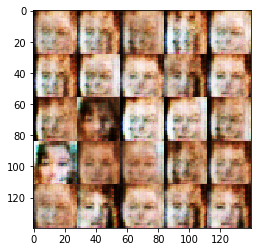

Epoch 3/6... Discriminator Loss: 1.0778... Generator Loss: 0.6824
Epoch 3/6... Discriminator Loss: 1.1184... Generator Loss: 1.4549
Epoch 3/6... Discriminator Loss: 0.9486... Generator Loss: 1.5444
Epoch 3/6... Discriminator Loss: 0.8346... Generator Loss: 0.9944


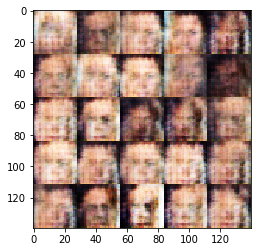

Epoch 3/6... Discriminator Loss: 0.6835... Generator Loss: 1.5862
Epoch 3/6... Discriminator Loss: 0.5526... Generator Loss: 2.0991
Epoch 3/6... Discriminator Loss: 0.7111... Generator Loss: 1.8762
Epoch 3/6... Discriminator Loss: 0.7165... Generator Loss: 1.7390


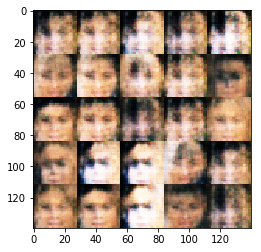

Epoch 3/6... Discriminator Loss: 0.7514... Generator Loss: 2.4520
Epoch 3/6... Discriminator Loss: 0.9330... Generator Loss: 1.1670
Epoch 3/6... Discriminator Loss: 0.6529... Generator Loss: 1.7253
Epoch 3/6... Discriminator Loss: 0.8104... Generator Loss: 1.5932


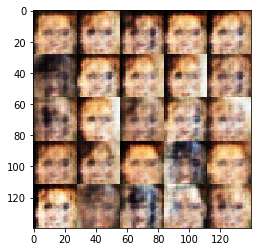

Epoch 3/6... Discriminator Loss: 1.2194... Generator Loss: 3.5508
Epoch 3/6... Discriminator Loss: 0.8825... Generator Loss: 2.4810
Epoch 3/6... Discriminator Loss: 1.3880... Generator Loss: 0.5336
Epoch 3/6... Discriminator Loss: 0.6983... Generator Loss: 1.3593


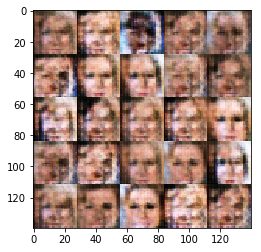

Epoch 3/6... Discriminator Loss: 1.4388... Generator Loss: 0.4829
Epoch 3/6... Discriminator Loss: 0.8510... Generator Loss: 1.0415
Epoch 3/6... Discriminator Loss: 0.9279... Generator Loss: 1.6128
Epoch 3/6... Discriminator Loss: 0.9445... Generator Loss: 0.8528


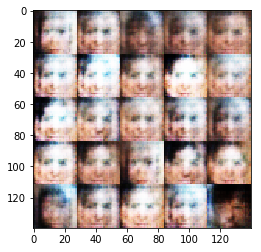

Epoch 3/6... Discriminator Loss: 0.9551... Generator Loss: 0.7786
Epoch 3/6... Discriminator Loss: 2.0007... Generator Loss: 0.2322
Epoch 3/6... Discriminator Loss: 0.8887... Generator Loss: 1.6558
Epoch 3/6... Discriminator Loss: 0.4973... Generator Loss: 1.8790


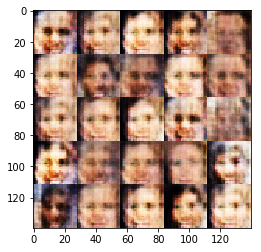

Epoch 3/6... Discriminator Loss: 0.9393... Generator Loss: 1.2263
Epoch 3/6... Discriminator Loss: 0.9503... Generator Loss: 1.0711
Epoch 3/6... Discriminator Loss: 0.8722... Generator Loss: 1.3953
Epoch 3/6... Discriminator Loss: 1.1445... Generator Loss: 0.6782


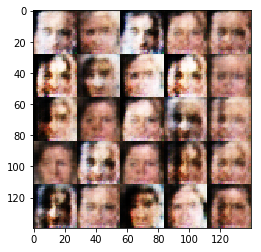

Epoch 3/6... Discriminator Loss: 0.9618... Generator Loss: 1.3917
Epoch 3/6... Discriminator Loss: 1.0065... Generator Loss: 1.3270
Epoch 4/6... Discriminator Loss: 0.8539... Generator Loss: 1.1219
Epoch 4/6... Discriminator Loss: 1.1903... Generator Loss: 0.8680


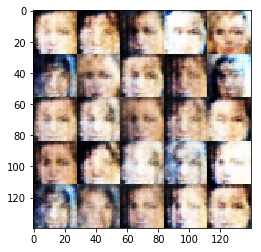

Epoch 4/6... Discriminator Loss: 0.8778... Generator Loss: 1.3423
Epoch 4/6... Discriminator Loss: 0.8124... Generator Loss: 1.3207
Epoch 4/6... Discriminator Loss: 0.6134... Generator Loss: 1.3880
Epoch 4/6... Discriminator Loss: 0.8329... Generator Loss: 1.3026


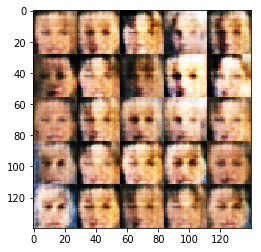

Epoch 4/6... Discriminator Loss: 1.4512... Generator Loss: 1.3755
Epoch 4/6... Discriminator Loss: 0.7667... Generator Loss: 1.1960
Epoch 4/6... Discriminator Loss: 0.9977... Generator Loss: 1.8113
Epoch 4/6... Discriminator Loss: 0.7948... Generator Loss: 1.5141


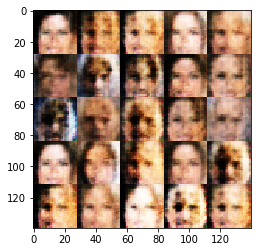

Epoch 4/6... Discriminator Loss: 0.9725... Generator Loss: 1.1522
Epoch 4/6... Discriminator Loss: 0.8343... Generator Loss: 1.5412
Epoch 4/6... Discriminator Loss: 1.0292... Generator Loss: 0.9377
Epoch 4/6... Discriminator Loss: 1.0917... Generator Loss: 1.0527


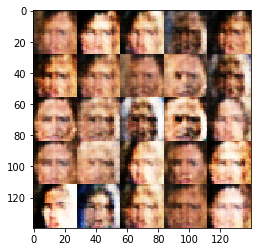

Epoch 4/6... Discriminator Loss: 1.1842... Generator Loss: 1.7495
Epoch 4/6... Discriminator Loss: 1.0620... Generator Loss: 0.7864
Epoch 4/6... Discriminator Loss: 1.3025... Generator Loss: 0.5578
Epoch 4/6... Discriminator Loss: 1.0256... Generator Loss: 1.5013


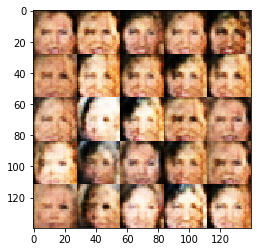

Epoch 4/6... Discriminator Loss: 1.0324... Generator Loss: 1.0599
Epoch 4/6... Discriminator Loss: 1.1755... Generator Loss: 2.3620
Epoch 4/6... Discriminator Loss: 1.1021... Generator Loss: 0.8183
Epoch 4/6... Discriminator Loss: 0.8387... Generator Loss: 1.1546


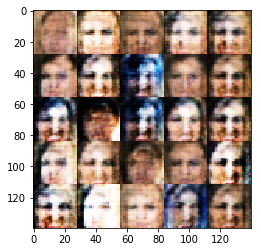

Epoch 4/6... Discriminator Loss: 1.0750... Generator Loss: 0.7760
Epoch 4/6... Discriminator Loss: 0.7484... Generator Loss: 1.4649
Epoch 4/6... Discriminator Loss: 1.1465... Generator Loss: 1.4049
Epoch 4/6... Discriminator Loss: 0.9057... Generator Loss: 1.6560


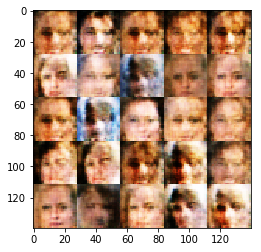

Epoch 4/6... Discriminator Loss: 0.8572... Generator Loss: 1.0882
Epoch 4/6... Discriminator Loss: 0.7890... Generator Loss: 1.9206
Epoch 4/6... Discriminator Loss: 1.0453... Generator Loss: 1.2788
Epoch 4/6... Discriminator Loss: 1.3508... Generator Loss: 0.5695


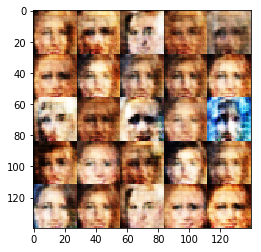

Epoch 4/6... Discriminator Loss: 0.9236... Generator Loss: 1.1976
Epoch 4/6... Discriminator Loss: 0.9178... Generator Loss: 1.4137
Epoch 4/6... Discriminator Loss: 0.8538... Generator Loss: 1.6302
Epoch 4/6... Discriminator Loss: 0.8053... Generator Loss: 1.4409


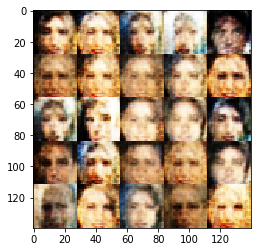

Epoch 4/6... Discriminator Loss: 2.0665... Generator Loss: 0.2217
Epoch 4/6... Discriminator Loss: 1.2952... Generator Loss: 2.2033
Epoch 4/6... Discriminator Loss: 1.1245... Generator Loss: 0.9330
Epoch 4/6... Discriminator Loss: 0.8875... Generator Loss: 1.5959


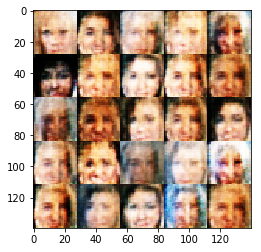

Epoch 4/6... Discriminator Loss: 0.9862... Generator Loss: 1.5685
Epoch 4/6... Discriminator Loss: 1.1893... Generator Loss: 1.8038
Epoch 5/6... Discriminator Loss: 1.1238... Generator Loss: 1.5024
Epoch 5/6... Discriminator Loss: 1.1459... Generator Loss: 0.8601


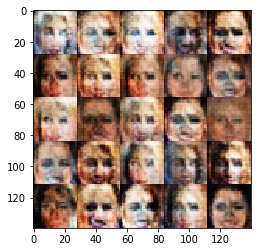

Epoch 5/6... Discriminator Loss: 0.9614... Generator Loss: 0.9785
Epoch 5/6... Discriminator Loss: 0.7768... Generator Loss: 1.7270
Epoch 5/6... Discriminator Loss: 1.2724... Generator Loss: 2.1123
Epoch 5/6... Discriminator Loss: 1.1669... Generator Loss: 0.9851


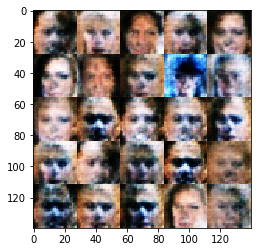

Epoch 5/6... Discriminator Loss: 0.7250... Generator Loss: 1.7261
Epoch 5/6... Discriminator Loss: 1.3206... Generator Loss: 0.5053
Epoch 5/6... Discriminator Loss: 1.0854... Generator Loss: 1.8483
Epoch 5/6... Discriminator Loss: 1.4133... Generator Loss: 0.4270


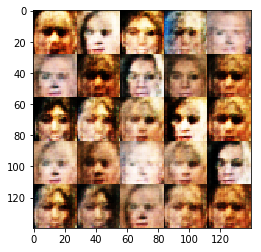

Epoch 5/6... Discriminator Loss: 1.1040... Generator Loss: 1.0398
Epoch 5/6... Discriminator Loss: 0.9264... Generator Loss: 1.3512
Epoch 5/6... Discriminator Loss: 0.9269... Generator Loss: 1.2645
Epoch 5/6... Discriminator Loss: 0.8860... Generator Loss: 1.6727


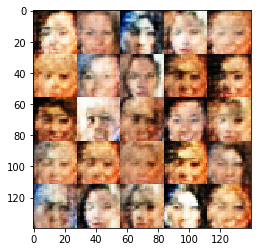

Epoch 5/6... Discriminator Loss: 1.7427... Generator Loss: 0.3256
Epoch 5/6... Discriminator Loss: 0.7597... Generator Loss: 1.2779
Epoch 5/6... Discriminator Loss: 0.9434... Generator Loss: 1.6153
Epoch 5/6... Discriminator Loss: 1.0084... Generator Loss: 1.4417


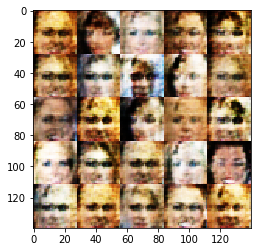

Epoch 5/6... Discriminator Loss: 1.2612... Generator Loss: 1.0045
Epoch 5/6... Discriminator Loss: 1.2982... Generator Loss: 2.3167
Epoch 5/6... Discriminator Loss: 1.4263... Generator Loss: 0.5404
Epoch 5/6... Discriminator Loss: 0.8365... Generator Loss: 1.3774


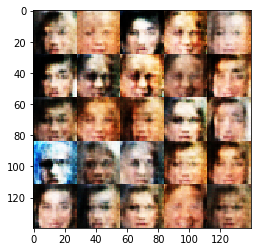

Epoch 5/6... Discriminator Loss: 0.9442... Generator Loss: 1.1019
Epoch 5/6... Discriminator Loss: 1.1044... Generator Loss: 1.1168
Epoch 5/6... Discriminator Loss: 1.0185... Generator Loss: 1.2164
Epoch 5/6... Discriminator Loss: 0.9252... Generator Loss: 1.6200


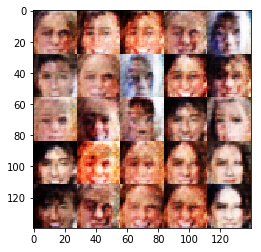

Epoch 5/6... Discriminator Loss: 0.8971... Generator Loss: 1.1632
Epoch 5/6... Discriminator Loss: 1.0312... Generator Loss: 0.9448
Epoch 5/6... Discriminator Loss: 0.8958... Generator Loss: 1.1853
Epoch 5/6... Discriminator Loss: 0.7947... Generator Loss: 1.4294


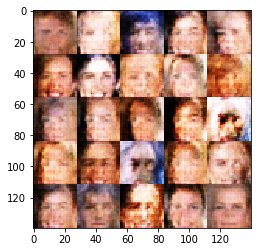

Epoch 5/6... Discriminator Loss: 0.9285... Generator Loss: 1.1970
Epoch 5/6... Discriminator Loss: 0.8598... Generator Loss: 1.7576
Epoch 5/6... Discriminator Loss: 0.9837... Generator Loss: 1.8536
Epoch 5/6... Discriminator Loss: 1.0431... Generator Loss: 2.0432


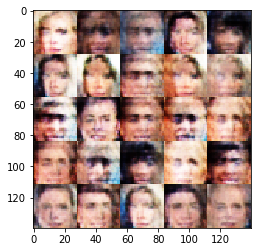

Epoch 5/6... Discriminator Loss: 1.2935... Generator Loss: 2.3863
Epoch 5/6... Discriminator Loss: 1.3323... Generator Loss: 0.5347


In [ ]:
batch_size = 512
z_dim = 110
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 6

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.